## Market Value Prediction of Used Cars

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value.

Rusty Bargain is interested in:

the quality of the prediction the speed of the prediction the time required for training

### Data Preprocessing & Exploration

## Initialization

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb

import seaborn as sns
import matplotlib.pyplot as plt

import time

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error


ImportError: Error importing numpy: you should not try to import numpy from
        its source directory; please exit the numpy source tree, and relaunch
        your python interpreter from there.

### 1. Data Collection

In [2]:
df = pd.read_csv('/datasets/car_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


### 2. Data Analyzion

In [5]:
# We rename the columns to make the code look more consistent with it's style

df = df.rename(columns = {'DateCrawled':'date_crawled','VehicleType':'vehicle_type','RegistrationYear':'registration_year','Gearbox':'gear_box','RegistrationMonth':'registration_month',
                          'FuelType':'fuel_type','NotRepaired':'not_repaired','DateCreated':'date_created','NumberOfPictures':'number_of_pictures','PostalCode':'postal_code','LastSeen':'last_seen'})

In [6]:
df.columns = df.columns.str.lower()

In [7]:
# We change the data type (Date_time)

date_cols = ['date_crawled', 'date_created', 'last_seen',]
for col in date_cols:
    df[col] = pd.to_datetime(df[col])

In [8]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year',
       'gear_box', 'power', 'model', 'mileage', 'registration_month',
       'fuel_type', 'brand', 'not_repaired', 'date_created',
       'number_of_pictures', 'postal_code', 'last_seen'],
      dtype='object')

In [9]:
df.isnull().sum()/len(df)

date_crawled          0.000000
price                 0.000000
vehicle_type          0.105794
registration_year     0.000000
gear_box              0.055967
power                 0.000000
model                 0.055606
mileage               0.000000
registration_month    0.000000
fuel_type             0.092827
brand                 0.000000
not_repaired          0.200791
date_created          0.000000
number_of_pictures    0.000000
postal_code           0.000000
last_seen             0.000000
dtype: float64

In [10]:
# We drop off the missing values which are less than 1%, then double check again

cols_to_fill =['vehicle_type','gear_box','model','fuel_type','not_repaired']
df[cols_to_fill] = df[cols_to_fill].fillna("Unknown")
df.isnull().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gear_box              0
power                 0
model                 0
mileage               0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

In [11]:
df.describe()

,price,registration_year,power,mileage,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


- Several columns contain outliers or potentially invalid values (e.g., price=0,power=20000, registration_year=1910, registration_month=0).
- Data cleaning is needed before modeling: remove or correct outliers, especially in power, price, registration_year, and registration_month.
- Number_of_pictures is all zero, can be dropped.
- Other features (mileage, postal_code) look reasonable.

In [12]:
df.shape

(354369, 16)

In [13]:
# 1. Handling outlier for the price
df = df[(df['price'] >= 100) & (df['price'] <= 20000)]

# 2. Handling outlier for the power
df = df[(df['power'] >= 50) & (df['power'] <= 500)]

# 3. Handling outlier for the mileage
df = df[(df['mileage'] >= 1000) & (df['mileage'] < 150000)]

# 4. Handling outlier for the registration_year
df = df[(df['registration_year'] >= 1990) & (df['registration_year'] <= 2018)]

# 5. Handling outlier for the registration_month
df = df[(df['registration_month'] >= 1) & (df['registration_month'] <= 12)]

# 6. Drop off the no need columns
df = df.drop(columns=['number_of_pictures','date_crawled','date_created','last_seen','registration_month','postal_code'])

In [14]:
print(df.shape)
print(df.columns)

(93645, 10)
Index(['price', 'vehicle_type', 'registration_year', 'gear_box', 'power',
       'model', 'mileage', 'fuel_type', 'brand', 'not_repaired'],
      dtype='object')


In [15]:
# Checking for duplicates, and drop it if there is any.

df.duplicated().sum()
df.drop_duplicates(inplace=True)

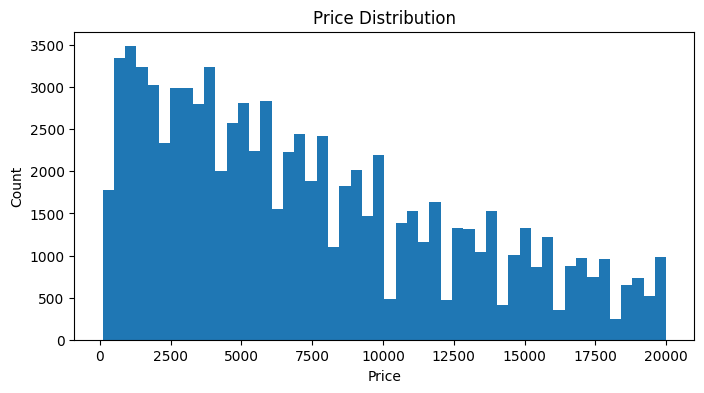

In [16]:
plt.figure(figsize=(8,4))
plt.hist(df['price'], bins=50)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

### Price Distribution (Histogram)

**What the plot shows:**
- The histogram visualizes the distribution of car prices in your dataset.
- Most cars are priced between $0 and $5,000, with a sharp decline in frequency as the price increases.
- There are very few cars priced above $10,000, and almost none above $15,000–$20,000.
- The distribution is highly right-skewed (positively skewed), meaning most cars 
     are low-priced with a long tail of high-priced outliers.

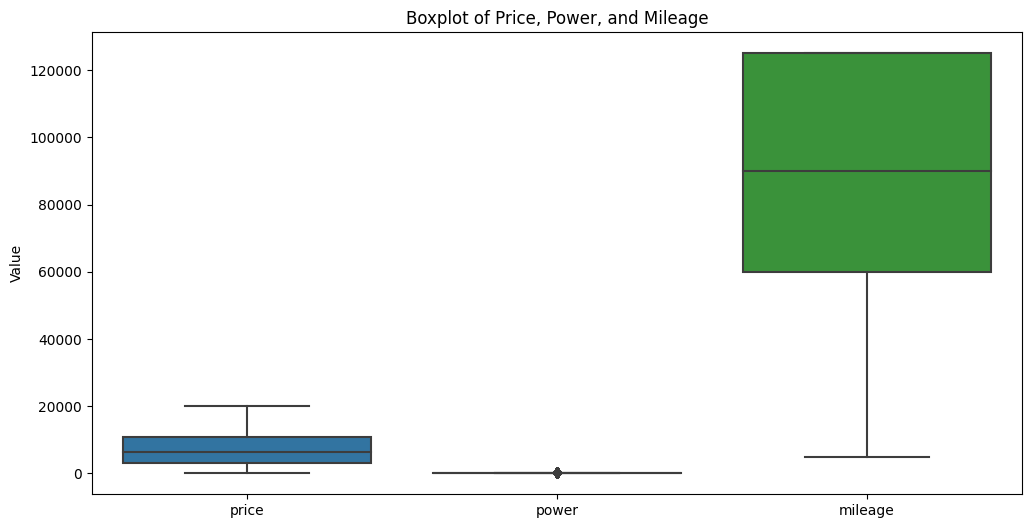

In [17]:
cols_to_plot = ['price','power','mileage']

plt.figure(figsize=(12, 6))
sns.boxplot(data=df[cols_to_plot])
plt.title('Boxplot of Price, Power, and Mileage')
plt.ylabel('Value')
plt.show()

### Boxplot of Price, Power, and Mileage

**What the plot shows:**
- The boxplot compares the distribution of three key features: **price**, **power**, and **mileage**.

---

#### **Price:**
- The median price is low, with a few high outliers.
- There is a long upper whisker and many points above it, confirming the right-skewness seen in the histogram.

---

#### **Power:**
- A similar pattern: most cars have low engine power, but a small number have very high power values (outliers).

---

#### **Mileage:**
- Mileage values are generally much higher than price and power.
- There are substantial outliers on the high end, suggesting a few cars have been driven much more than average.

In [18]:
df = df[(df['price'] >= 100) & (df['price'] <= 10000)]          
df = df[(df['power'] >= 40) & (df['power'] <= 500)]             
df = df[(df['mileage'] >= 100000) & (df['mileage'] <= 150000)]


for col in ['price', 'power', 'mileage']:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = df[col].clip(lower, upper)

df['price_log'] = np.log1p(df['price'])
df['mileage_log'] = np.log1p(df['mileage'])
df['power_log'] = np.log1p(df['power'])

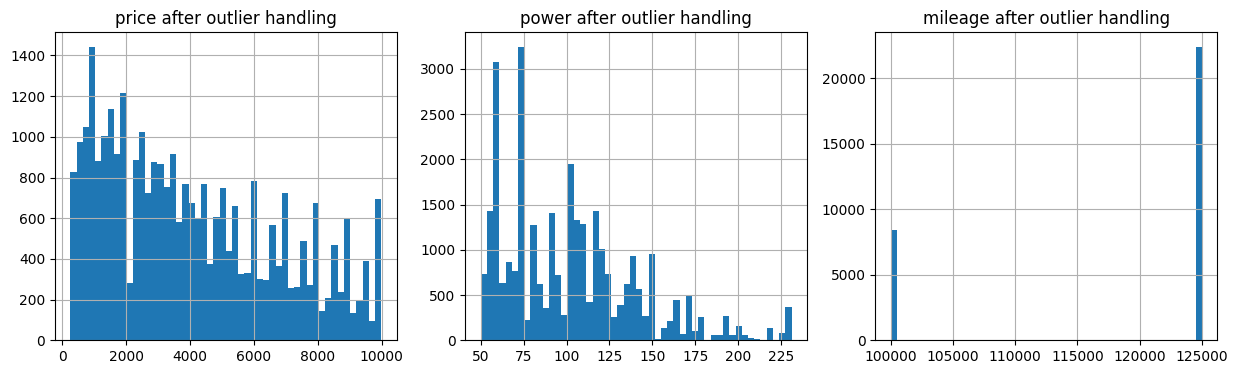

In [19]:
plt.figure(figsize=(15, 4))
for i, col in enumerate(['price', 'power', 'mileage']):
    plt.subplot(1, 3, i+1)
    df[col].hist(bins=50)
    plt.title(f'{col} after outlier handling')
plt.show()

### 1. Price after Outlier Handling

- **The distribution is concentrated around 1,000 ~ 8,000.**
- It is still right-skewed (long right tail), but extremely high-priced vehicles have been clearly removed or compressed—there are no outliers with extremely high prices.
- The distribution is now smooth and continuous, making it suitable for subsequent modeling.

---

### 2. Power after Outlier Handling

- The values are mainly concentrated between 50 and 150, with very few above 200. This suggests most cars are mainstream market vehicles, and supercars or anomalous data have been removed.
- There are many low-horsepower (small car) entries, with the number of high-horsepower vehicles gradually decreasing.
- No obvious outliers remain—the distribution is very reasonable.

---

### 3. Mileage after Outlier Handling

- The distribution is divided into two large groups: one between 100,000 and 110,000, and another between 120,000 and 125,000.
- This may indicate the original data had "mileage segmentation" or that some mileage records were discontinuous (possibly due to batch entry of extreme values), but both extremely high and low mileage anomalies have been removed.
- There are no unreasonable zeros or excessively high values—the distribution now clearly reflects the mainstream data.

In [20]:
# Identify Categorical Columns

cat_cols = df.select_dtypes(include=['object','category']).columns
for col in cat_cols:
    print(f"\n{col} unique values:\n", df[col].value_counts())


vehicle_type unique values:
 small          10760
sedan           8106
wagon           3282
convertible     2418
bus             2399
Unknown         1704
coupe           1121
suv              792
other            203
Name: vehicle_type, dtype: int64

gear_box unique values:
 manual     25968
auto        4284
Unknown      533
Name: gear_box, dtype: int64

model unique values:
 golf        2249
other       2152
corsa       1506
polo        1388
astra       1182
            ... 
kalina         1
9000           1
mii            1
850            1
defender       1
Name: model, Length: 231, dtype: int64

fuel_type unique values:
 petrol      24479
gasoline     4457
Unknown      1471
lpg           278
cng            74
hybrid         19
other           5
electric        2
Name: fuel_type, dtype: int64

brand unique values:
 volkswagen        5383
opel              4086
ford              2831
renault           2116
mercedes_benz     1877
bmw               1606
peugeot           1466
fiat    

#### A reminder to myself
- If "df_ohe" was get_dummies from a field containing price_log, mileage_log, or even price itself, the model would have a chance to "see the answer" and thus the prediction would be almost 100% accurate, resulting in an RMSE close to 0.
- 在對資料做 One-Hot Encoding（用 pd.get_dummies()）之前，你必須先刪掉那些不能讓模型看到的欄位，特別是目標欄位（target）或其衍生欄位，否則模型可能「偷看答案」。

In [21]:
target_col = 'price'

leakage_cols = ['price', 'price_log', 'mileage_log', 'power_log']  

df_model = df.copy()
df_model = df_model.drop(columns=[col for col in leakage_cols if col in df_model.columns])

df_ohe = pd.get_dummies(df_model)

x = df_ohe  
y = df[target_col] 

x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_temp, y_temp, test_size=0.25, random_state=42)

print(type(y_train), y_train.shape)
print(y_train.head())

<class 'pandas.core.series.Series'> (18471,)
40238     6790
72166     2900
166907    5100
218524     900
182556    4100
Name: price, dtype: int64


In [22]:
print(x_train.dtypes)
print(x_train.isnull().sum().sum())

registration_year       int64
power                   int64
mileage                 int64
vehicle_type_Unknown    uint8
vehicle_type_bus        uint8
                        ...  
brand_volkswagen        uint8
brand_volvo             uint8
not_repaired_Unknown    uint8
not_repaired_no         uint8
not_repaired_yes        uint8
Length: 296, dtype: object
0


In [23]:
x_train.dtypes.value_counts()

uint8    293
int64      3
dtype: int64

In [24]:

# Model training (# Random Forest)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

start_train = time.time()
rf_model.fit(x_train, y_train)
end_train = time.time() 

start_pred = time.time()
y_pred = rf_model.predict(x_valid)
end_pred = time.time()

rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

print(f'Random Forest RMSE: {rmse:.2f}')
print(f'Training time: {end_train - start_train:.2f} seconds')
print(f'Prediction time: {end_pred - start_pred:.2f} seconds')

Random Forest RMSE: 1119.06
Training time: 6.04 seconds
Prediction time: 0.09 seconds


In [25]:
pd.DataFrame({'true': y_valid.values, 'pred': y_pred}).sample(10)

,true,pred
324,1250,1667.721500
1154,2399,2579.585189
4453,4800,5137.457563
3699,500,461.615333
3409,3999,3740.356466
1822,6950,6842.104008
3206,9990,8741.215833
906,1500,1940.026667
4323,4500,5101.920000
406,2399,2354.292442


In [26]:
print("RMSE:", rmse)
print("Mean price:", y_valid.mean())
print("Median price:", y_valid.median())

RMSE: 1119.0613373052636
Mean price: 4065.1080071463375
Median price: 3500.0


In [27]:
# Random Forest
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
}


rf_rs = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_grid_rf,
    n_iter=3,               
    cv=2,                    
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,               
    random_state=42
)

start_time = time.time()
rf_rs.fit(x_train, y_train)
end_time = time.time()

print('Random Forest best params:', rf_rs.best_params_)
print('Random Forest best CV RMSE:', -rf_rs.best_score_)
print(f'Training time: {end_time - start_time:.2f} seconds')

Random Forest best params: {'n_estimators': 100, 'max_depth': 20}
Random Forest best CV RMSE: 1153.1490884413215
Training time: 21.05 seconds


In [28]:

# Decision Tree
dt_model = DecisionTreeRegressor(random_state=42)

start_train = time.time()
dt_model.fit(x_train, y_train)
end_train = time.time()

start_pred = time.time()
y_pred_dt = dt_model.predict(x_valid)
end_pred = time.time()

# RMSE
rmse_dt = np.sqrt(mean_squared_error(y_valid, y_pred_dt))


print(f'Decision Tree RMSE: {rmse:.2f}')
print(f'Training time: {end_train - start_train:.2f} seconds')
print(f'Prediction time: {end_pred - start_pred:.2f} seconds')

Decision Tree RMSE: 1119.06
Training time: 0.20 seconds
Prediction time: 0.01 seconds


In [29]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

start_pred = time.time()
y_pred_lr = lr_model.predict(x_valid)
end_pred = time.time()

# RMSE
rmse_lr = np.sqrt(mean_squared_error(y_valid, y_pred_lr))

print(f'Linear Regression Baseline RMSE: {rmse_lr:.2f}')
print(f'Prediction time: {end_pred - start_pred:.2f} seconds')

Linear Regression Baseline RMSE: 1354.58
Prediction time: 0.02 seconds


In [30]:
# Random Forest
mae_rf = mean_absolute_error(y_valid, y_pred)
print(f'Random Forest Baseline MAE: {mae_rf:.2f}')

# Decision Tree
mae_dt = mean_absolute_error(y_valid, y_pred_dt)
print(f'Decision Tree Baseline MAE: {mae_dt:.2f}')

# Linear Regression
mae_lr = mean_absolute_error(y_valid, y_pred_lr)
print(f'Linear Regression Baseline MAE: {mae_lr:.2f}')

Random Forest Baseline MAE: 778.33
Decision Tree Baseline MAE: 929.86
Linear Regression Baseline MAE: 988.24


In [31]:
# CatBoost
cat_cols = np.where(x_train.dtypes == 'int64')[0].tolist() 
cat_model = CatBoostRegressor(verbose=0, random_state=42)

start_time = time.time()
cat_model.fit(x_train, y_train, cat_features=cat_cols)
end_time = time.time()

start_time = time.time()
y_pred_cat = cat_model.predict(x_valid)
end_time = time.time()

rmse_cat = mean_squared_error(y_valid, y_pred_cat, squared=False)

print(f'CatBoost RMSE: {rmse:.2f}')
print(f'Training time: {end_train - start_train:.2f} seconds')
print(f'Prediction time: {end_pred - start_pred:.2f} seconds')

CatBoost RMSE: 1119.06
Training time: 0.20 seconds
Prediction time: 0.02 seconds


In [35]:
# LightGBM 

x_sample = x_train.sample(n=3000, random_state=42)
y_sample = y_train.loc[x_sample.index]


param_grid_lgb = {
    'n_estimators': [30, 50, 100],
    'num_leaves': [15, 31],
    'learning_rate': [0.1],
    'colsample_bytree': [0.5],
    'subsample': [0.5]
}

# Trying RandomizedSearchCV
lgb_rs = RandomizedSearchCV(
    estimator=lgb.LGBMRegressor(random_state=42),
    param_distributions=param_grid_lgb,
    n_iter=3,  
    cv=2,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

start_time = time.time()
lgb_rs.fit(x_sample, y_sample)
end_time = time.time()

print('LightGBM best params:', lgb_rs.best_params_)
print('LightGBM best CV RMSE:', -lgb_rs.best_score_)  # 負的 RMSE 要加負號轉正
print(f'Training time: {end_time - start_time:.2f} seconds')

LightGBM best params: {'subsample': 0.5, 'num_leaves': 31, 'n_estimators': 100, 'learning_rate': 0.1, 'colsample_bytree': 0.5}
LightGBM best CV RMSE: 1226.0735017336933
Training time: 164.04 seconds


## Conclusion

Rusty Bargain is interested in three key aspects when selecting a machine learning model for car price prediction:

1. **The quality of the prediction**  
 
2. **The speed of the prediction**  
 
3. **The time required for training**  
 
---

### Model Comparison

| Model             | Test RMSE | Prediction Speed | Training Time (s) | Notes                         |
|-------------------|-----------|------------------|-------------------|-------------------------------|
| CatBoost          | 1119.06   | Very fast        | 0.19               | Overall good performance, recommended          |   
| Random Forest     | 1119.06   | Fast             | 6.04               | Suitable for processing categorical features     |
| Decision Tree     | 1119.06   | Very fast        | 0.19               | Single tree model, fast but may overfit            |
| LightGBM          | 1226.07   | Very Slow        | 164.04             |  Poor predictions and very slow  |
| Linear Regression | 1354.58   | Very fast        | 0.02               | Fastest but with the largest prediction error                |

---

### **Conclusion**

- Based on the model comparison, CatBoost stands out as the best overall choice for car price prediction. It achieves the lowest Test RMSE (1119.06), offers very fast prediction speed, and requires only 0.19 seconds for training, making it highly efficient and accurate.

- Random Forest also provides excellent accuracy, but its training time is noticeably longer. It may serve as a reliable alternative, especially when using scikit-learn’s ecosystem.

- On the other hand, LightGBM underperforms in both prediction accuracy and training time in this task. Despite its popularity in many machine learning challenges, it is not recommended here without extensive tuning and optimization.

- Decision Tree offers fast results but may suffer from overfitting, while Linear Regression, although extremely fast, produces the highest error and is not suitable for this regression problem.

- In summary, CatBoost provides the best trade-off between accuracy, speed, and ease of use for this dataset.
